In [16]:
import xgboost as xgb
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import accuracy_score
import pandas as pd
from sklearn.metrics import roc_curve
import numpy as np
from sklearn.metrics import roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split


In [2]:
df = pd.read_csv('./HN_P2C.csv')

/var/folders/6g/jsvgykrx6q53bm52dz7x1ldm0000gn/T/ipykernel_4002/1672303896.py:1: DtypeWarning: Columns (12,17,20) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('./HN_P2C.csv')


The following cell creates a new DataFrame with just the rows that have 'Healthy' and 'Cancer' in CLabel

In [3]:
print(df.iloc[:, 77:95].dtypes)
df_new = df[df['CLabel'].isin(['Healthy', 'Cancer'])]
df_new.to_csv('df_new.csv', index=False)
df_new.head()

df = df_new
df.info()

Phasor_GH1_ch1    float64
Phasor_SH1_ch1    float64
Phasor_GH1_ch2    float64
Phasor_SH1_ch2    float64
Phasor_GH1_ch3    float64
Phasor_SH1_ch3    float64
Phasor_GH2_ch1    float64
Phasor_SH2_ch1    float64
Phasor_GH2_ch2    float64
Phasor_SH2_ch2    float64
Phasor_GH2_ch3    float64
Phasor_SH2_ch3    float64
Phasor_GH3_ch1    float64
Phasor_SH3_ch1    float64
Phasor_GH3_ch2    float64
Phasor_SH3_ch2    float64
Phasor_GH3_ch3    float64
Phasor_SH3_ch3    float64
dtype: object
<class 'pandas.core.frame.DataFrame'>
Index: 128459 entries, 1369 to 202269
Columns: 101 entries, Case to CLabel
dtypes: float64(71), int64(9), object(21)
memory usage: 100.0+ MB


The following cell initializes the Cross-Validation and the XGBoost Classifier. 

In [4]:
df.columns

Index(['Case', 'Run', 'Anatomy', 'ScanContext', 'Instrument', 'Setup',
       'Diagnosis', 'HPVstatus', 'TobbacoStatus', 'OccultPrimary',
       ...
       'Phasor_GH3_ch2', 'Phasor_SH3_ch2', 'Phasor_GH3_ch3', 'Phasor_SH3_ch3',
       'WLI_distance_fromMargin', 'WLI_frame_n', 'WLI_x_coord', 'WLI_y_coord',
       'Label', 'CLabel'],
      dtype='object', length=101)

In [5]:
loo = LeaveOneOut()
model = xgb.XGBClassifier()

Assign independent and dependent variables. 
Bring in the features we are interested in as a big array. 
No need for test and train sets as each point gets to be a test point once and a train point 99 times.

Also, encode `Cancer` as 1 and `Healthy` as 0.

In [6]:
features_of_interest = [
    'lifet_avg_ch1', 'lifet_avg_ch2', 'lifet_avg_ch3', 
    'int_ratio_ch1', 'int_ratio_ch2', 'int_ratio_ch3',
    'Laguerre_coeffs_1_ch1', 'Laguerre_coeffs_2_ch1', 'Laguerre_coeffs_3_ch1', 
    'Laguerre_coeffs_4_ch1', 'Laguerre_coeffs_5_ch1', 'Laguerre_coeffs_6_ch1', 
    'Laguerre_coeffs_7_ch1', 'Laguerre_coeffs_8_ch1', 'Laguerre_coeffs_9_ch1', 
    'Laguerre_coeffs_10_ch1', 'Laguerre_coeffs_11_ch1', 'Laguerre_coeffs_12_ch1',
    'Laguerre_coeffs_1_ch2', 'Laguerre_coeffs_2_ch2', 'Laguerre_coeffs_3_ch2', 
    'Laguerre_coeffs_4_ch2', 'Laguerre_coeffs_5_ch2', 'Laguerre_coeffs_6_ch2', 
    'Laguerre_coeffs_7_ch2', 'Laguerre_coeffs_8_ch2', 'Laguerre_coeffs_9_ch2', 
    'Laguerre_coeffs_10_ch2', 'Laguerre_coeffs_11_ch2', 'Laguerre_coeffs_12_ch2',
    'Laguerre_coeffs_1_ch3', 'Laguerre_coeffs_2_ch3', 'Laguerre_coeffs_3_ch3', 
    'Laguerre_coeffs_4_ch3', 'Laguerre_coeffs_5_ch3', 'Laguerre_coeffs_6_ch3', 
    'Laguerre_coeffs_7_ch3', 'Laguerre_coeffs_8_ch3', 'Laguerre_coeffs_9_ch3', 
    'Laguerre_coeffs_10_ch3', 'Laguerre_coeffs_11_ch3', 'Laguerre_coeffs_12_ch3'
]

X = df[features_of_interest]
df['CLabel'] = df['CLabel'].map({'Cancer':1, 'Healthy':0})
y = df['CLabel']

**Plotting Function**

In [13]:
def plot_roc_curve(y_true, y_scores, auc_score):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc_score)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Create the loop for the LOO cross-validation.

The LeaveOneOut object (loo) has functionality to appropriately split 'X' into train and test sets, where the test set only has 1 data point (patient). This is how each learning set is created. 

Results are then stored in the accuracies array, upon which further calculations are performed. 

The loop has 100 iterations, to simulate the first 100 patients in the V4 dataset. However, as of now, the loop, and the  `loo` cross-validation run on the HN_P2C data.

The loop also jumps 500 rows every iteration so that it doesn't focus on a series of rows that are all `healthy` - a mask is used to achieve this

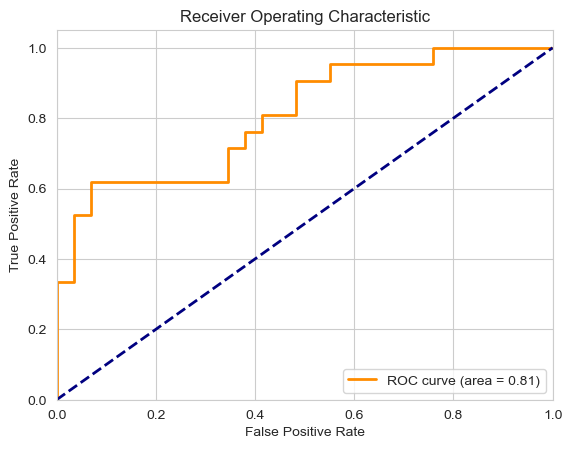

Average Accuracy:  0.66
Standard Deviation of Accuracy:  0.4737087712930805
ROC AUC:  0.8078817733990148


In [15]:
step_size = 1000
counter = 0

# Store accuracy and predicted probabilities
accuracies = []
y_true_all = []  # Store all actual labels
y_pred_proba_all = []  # Store all predicted probabilities

# Loop in steps of 'step_size'
for i in range(0, len(X), step_size):
    mask = np.zeros(len(X), dtype=bool)
    mask[i] = True  # Select the i-th element 

    # Split
    X_train, X_test = X[~mask], X[mask]
    y_train, y_test = y[~mask], y[mask]

    # Fit on training sets
    model.fit(X_train, y_train)

    # Test
    y_pred = model.predict(X_test) #class prediction for the test data
    y_pred_proba = model.predict_proba(X_test)[:, 1] #probability prediction for the test data (prob. of the positive class)

    # Calculate accuracies
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    # Store actual labels and predicted probabilities for ROC AUC calculation
    y_true_all.extend(y_test)
    y_pred_proba_all.extend(y_pred_proba)
    
    counter += 1
    if counter == 50:
        break

# Average and StdDev of accuracies
average_accuracy = np.mean(accuracies)
std_dev_accuracy = np.std(accuracies)

# Calculate ROC AUC - using actual labels and predicted probabilities
roc_auc = roc_auc_score(y_true_all, y_pred_proba_all)
plot_roc_curve(y_true_all, y_pred_proba_all, roc_auc)

print("Average Accuracy: ", average_accuracy)
print("Standard Deviation of Accuracy: ", std_dev_accuracy)
print("ROC AUC: ", roc_auc)

**Mask Logic:**

- used to selectively include or exclude data points from the training and test sets during each iteration of the loop. 

- `mask = np.zeros(len(X), dtype=bool)` is initialized as a boolean array of the same length as the dataset that is filled with false values (so no element is selected)

- In every iteration, the `i-th` data point in the dataset is selected for testing, and since `i` increments by `step_size` (1000), this picks every 1000th data point

- The mask is then used when splitting the data into training and test sets

- `X[mask]` and `y[mask]` get the data points where `mask` is true. Therefore, `X_test` and `y_test` contain the 1000th data point. `X[~mask]` and `y[~mask]` get all the other points (where `mask` is false)


**ROC Info:**

- ROC Curve is a graphical representation that illustrates binary classification performance

- It plots the TPR (sensitivity) against the FPR (1 - specificity) at different threshold settings

- Each point on the ROC curve represents a sensitivity/specificity pair


**AUC Info:**

- AUC measures the area (like an integral) under the ROC Curve

- The AUC value summarizes the performance of a classifier across different threshold values. A threshod value is a point in the 0.0 - 1.0 range where the class labels change (from `Healthy` to `Cancer` for example). Higher the AUC score the better.


**Below is the code to calculate conditional ROC AUC values:**

- perform classification wrt nature of DS
- partition DS wrt patients - 1000 steps can hit different patient data
- filter by patient level

- Interpretability project tasks
- load pkl file need score and ground truth (Gt)

- unpackp pkl, gets u model and dataset
- pkl file has a XGBoost model, and run a shap

1) understand why the model performed as it did (for good and bad cases)
2) based on the findings, can we improve the model

extract the features from the dataframe in the pkl file and run it through the model

- no training
- to begin 

In [23]:
#sample 100 points of 'Cancer' and 'Healthy'. Random state for reproducible sample
df_cancer = df[df['CLabel'] == 1].sample(n=100, random_state=42)
df_healthy = df[df['CLabel'] == 0].sample(n=100, random_state=42)

#create a new dataframe (100 of each class)
df_sampled = pd.concat([df_cancer, df_healthy])

#Select the features and the target variables from df_sampled
X_sampled = df_sampled[features_of_interest]
y_sampled = df_sampled['CLabel']

#initialize instances of XGBoost Classifier and LOO
model_sampled = xgb.XGBClassifier()
loo_sampled = LeaveOneOut()

#data structures to hold calculated values for each iteration of the for loop
accuracies_sampled = []
y_true_sampled = []
y_pred_proba_sampled = []
y_pred_sampled = []


#new for loop. Each iteration uses one sample for testing and the rest for training
for train_index, test_index in loo_sampled.split(X_sampled):\
    #these lines split the features and target into training and test sets based on loo_sampled indices
    X_train_sampled, X_test_sampled = X_sampled.iloc[train_index], X_sampled.iloc[test_index]
    y_train_sampled, y_test_sampled = y_sampled.iloc[train_index], y_sampled.iloc[test_index]
    
    # Fit model on sampled dataset
    model_sampled.fit(X_train_sampled, y_train_sampled)
    
    y_pred = model_sampled.predict(X_test_sampled)[0]
    
    accuracies_sampled.append(accuracy_score(y_test_sampled, [y_pred]))
    
    y_true_sampled.append(y_test_sampled.iloc[0])
    y_pred_sampled.append(y_pred)  # This line should append a new prediction in each iteration

# After the loop, check the lengths
print("Length of y_true_sampled:", len(y_true_sampled))
print("Length of y_pred_sampled:", len(y_pred_sampled))
    
# Calculate average accuracy and its standard deviation for the sampled dataset
average_accuracy_sampled = np.mean(accuracies_sampled)
std_dev_accuracy_sampled = np.std(accuracies_sampled)

# Calculate ROC AUC for the sampled dataset
roc_auc_sampled = roc_auc_score(y_true_sampled, y_pred_proba_sampled)
plot_roc_curve(y_true_sampled, y_pred_proba_sampled, roc_auc_sampled)

if len(y_true_sampled) != len(y_pred_sampled):
    print("Mismatch found:")
    print("Length of y_true_sampled:", len(y_true_sampled))
    print("Length of y_pred_sampled:", len(y_pred_sampled))
    # Handle the mismatch appropriately
    # For example, you can truncate the longer list or investigate why the mismatch occurs
else:
    # Proceed with the confusion matrix and further calculations
    conf_matrix = confusion_matrix(y_true_sampled, y_pred_sampled)

    TP = conf_matrix[1, 1]
    TN = conf_matrix[0, 0]
    FP = conf_matrix[0, 1]
    FN = conf_matrix[1, 0]

    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

print("Sensitivity: ", sensitivity)
print("Specificity: ", specificity)

print("- Average Accuracy (Sampled): ", average_accuracy_sampled)
print("- Standard Deviation of Accuracy (Sampled): ", std_dev_accuracy_sampled)
print("- ROC AUC (Sampled): ", roc_auc_sampled)
print("- Sensitivity: ", sensitivity)
print("- Specificity: ", specificity)


Length of y_true_sampled: 200
Length of y_pred_sampled: 200


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.